In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import datetime
import random
import sys
import os
import argparse

import numpy as np
from tqdm import tqdm, trange
from ptflops import get_model_complexity_info
from torchinfo import summary
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

sys.path.append("/home/geshi/ChaosMining")

from chaosmining.data_utils import ChaosVisionDataset
from chaosmining.utils import check_make_dir
from chaosmining.vision import parse_argument, train_epoch, test

from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation, visualization

In [3]:
import captum
captum.__version__

'0.7.0'

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
from scipy.ndimage import gaussian_filter 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
batch_size = 16
num_classes = len(classes)
n_steps = 20
saveflag = True

# Load Data and Model

In [9]:
# define transforms

class ToTensor(object):
    """Convert values in landmarks to Tensors."""
    def __call__(self, landmarks):
        return [torch.tensor(landmark) for landmark in landmarks]

data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

target_transform = transforms.Compose([
        ToTensor(),
    ])

In [10]:
# load data
root_dir = '/data/home/geshi/ChaosMining/data/vision/SBFP/'
val_data = os.path.join(root_dir, 'val')
val_csv_file = os.path.join(val_data, 'meta_data.csv')
valset = ChaosVisionDataset(val_data, val_csv_file, transform=data_transform, target_transform=target_transform)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

target_names = valset.get_target_names()
target_index = target_names.index('foreground_label')

In [11]:
model =  models.get_model('googlenet', weights='DEFAULT')

In [12]:
# prepare for training
model = nn.Sequential(
    model,
    nn.Linear(1000, num_classes)
)

model.eval()
sample_shape = (1, 3, 224, 224)
summary(model, input_size=sample_shape)

model.to(device)

Sequential(
  (0): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): Batc

In [13]:
model_path = '../runs/vision/SBFP/arc_googlenet_seed_9999/01-06-2024-20:16:04.pt'
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
model.eval()

Sequential(
  (0): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): Batc

In [14]:
val_stats = test(model, val_loader, target_index, num_classes, device, (1, 5)) 
print(val_stats)

Test: 100%|████████████████| 625/625 [00:22<00:00, 27.56batch/s, accuracy=80.8]

Testing complete in 0m 23s, Test Acc: 80.81
{'test_top1_acc': 80.81, 'test_top5_acc': 97.61}


# Local XAI localization

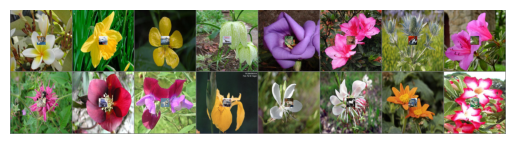

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [15]:
def imshow(timg):
    timg = timg / 2 + 0.5     # unnormalize
    npimg = timg.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # plt.show()

dataiter = iter(val_loader)
images, targets = next(dataiter)
images = images.to(device)
labels = targets[target_index]

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = model(images)

_, predicted = torch.max(outputs, 1)
positions = (targets[-2].numpy(), targets[-1].numpy())
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [16]:
_, preds = outputs.topk(1)

In [17]:
ig = IntegratedGradients(model)
sa = Saliency(model)
dl = DeepLift(model)
fa = FeatureAblation(model)

In [18]:
sample_idx = 5
sigma = 6
fg_size = (32, 32)
pos = (positions[0][sample_idx], positions[1][sample_idx])

In [19]:
def get_box(attr_sample, size, sign="absolute_value"):
    if sign=="absolute_value":
        attr_sample = np.abs(attr_sample)
        attr_sample = attr_sample.mean(axis=-1)
    elif sign=="positive":
        attr_sample[attr_sample<0] = 0
        attr_sample = attr_sample.mean(axis=-1)
    elif sign=="negative":
        attr_sample[attr_sample>0] = 0
        attr_sample = np.abs(attr_sample)
        attr_sample = attr_sample.mean(axis=-1)
    else:
        attr_sample = attr_sample.mean(axis=-1)
    threshold = -np.partition(-attr_sample.flatten(), size)[size]
    pos = np.argwhere(attr_sample > threshold)
    min_x, max_x, min_y, max_y = pos[:,0].min(), pos[:,0].max(), pos[:,1].min(), pos[:,1].max()
    return min_x, max_x, min_y, max_y

In [20]:
def show_rects(pred, gtrue, attr_sample):
    min_x, min_y, max_x, max_y = pred
    min_xt, min_yt, max_xt, max_yt = gtrue
    fig, ax = plt.subplots()

    norm_attr_sample = np.floor((attr_sample-attr_sample.min())/attr_sample.max()*255).astype(int).mean(axis=-1)
    # Display the image
    ax.imshow(norm_attr_sample, cmap='Blues')

    # Create a Rectangle patch
    pred_rec = patches.Rectangle((min_y, min_x), max_y-min_y, max_x-min_x, linewidth=1, edgecolor='red', facecolor='none')
    true_rec = patches.Rectangle((min_yt, min_xt), max_yt-min_yt, max_xt-min_xt, linewidth=1, edgecolor='yellow', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(pred_rec)
    ax.add_patch(true_rec)
    plt.axis('off')
    #plt.show()

In [21]:
def calculate_iou(rectangle1, rectangle2):
    """
    Calculate Intersection over Union (IoU) between two rectangles.

    Parameters:
    - rectangle1: Tuple (x1, y1, width1, height1) representing the first rectangle.
    - rectangle2: Tuple (x2, y2, width2, height2) representing the second rectangle.

    Returns:
    - IoU score between the two rectangles.
    """

    # Extracting coordinates and dimensions
    x1, y1, width1, height1 = rectangle1
    x2, y2, width2, height2 = rectangle2

    # Calculating coordinates of the intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    x_intersection_end = min(x1 + width1, x2 + width2)
    y_intersection_end = min(y1 + height1, y2 + height2)

    # Calculating area of the intersection rectangle
    intersection_width = max(0, x_intersection_end - x_intersection)
    intersection_height = max(0, y_intersection_end - y_intersection)
    intersection_area = intersection_width * intersection_height

    # Calculating area of the union
    area1 = width1 * height1
    area2 = width2 * height2
    union_area = area1 + area2 - intersection_area

    # Calculating IoU score
    iou_score = intersection_area / union_area if union_area != 0 else 0  # Avoid division by zero

    return iou_score

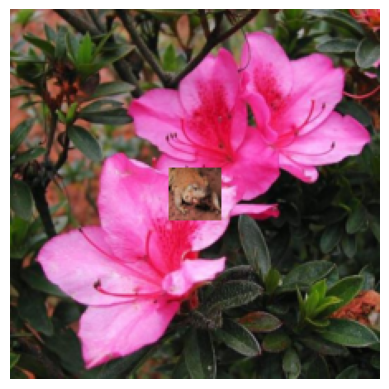

In [22]:
imshow(images[sample_idx])
if saveflag:
    plt.savefig("sample", dpi=300, bbox_inches='tight')

## Saliency

In [23]:
sa_attr = sa.attribute(images, target=preds.view(-1))
sa_attr_sample = np.transpose(sa_attr[sample_idx].squeeze().cpu().detach().numpy(), (1, 2, 0))

/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


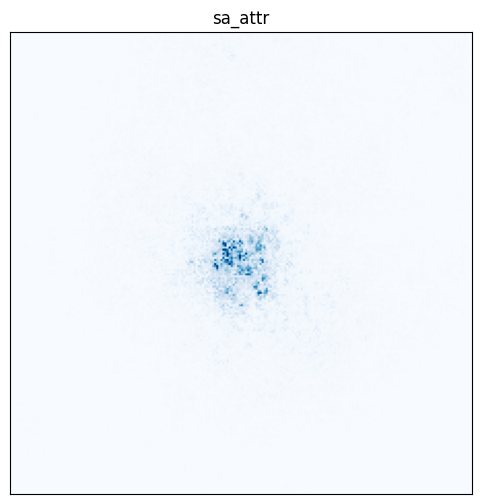

In [24]:
_ = visualization.visualize_image_attr(sa_attr_sample, method="heat_map", title="sa_attr", sign="absolute_value")

In [25]:
smooth_sa_attr_sample = gaussian_filter(sa_attr_sample, sigma=sigma)

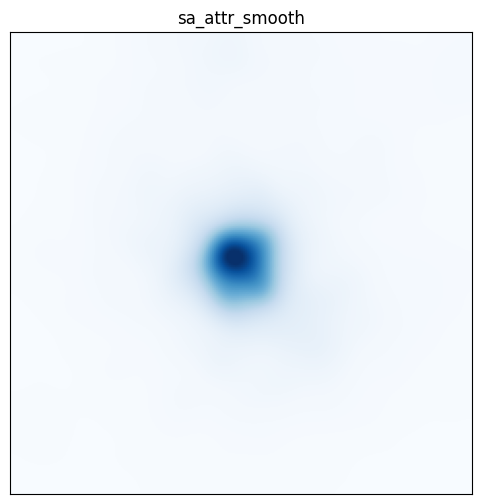

In [26]:
_ = visualization.visualize_image_attr(smooth_sa_attr_sample, method="heat_map", title="sa_attr_smooth", sign="absolute_value")

In [27]:
min_x, max_x, min_y, max_y = get_box(smooth_sa_attr_sample, np.prod(fg_size))

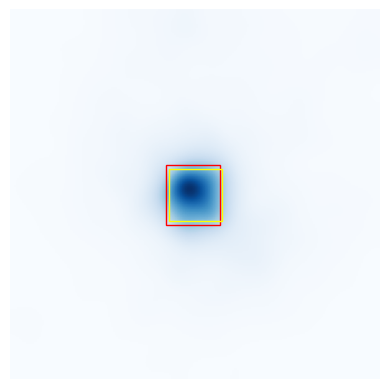

In [28]:
show_rects((min_x, min_y, max_x, max_y), (pos[0], pos[1], pos[0]+32, pos[1]+32), smooth_sa_attr_sample)
if saveflag:
    plt.savefig("SA", dpi=300, bbox_inches='tight')

In [29]:
print('iou score is', calculate_iou((min_x, min_y, max_x-min_x, max_y-min_y), (pos[0], pos[1], 32, 32)))

iou score is 0.8131147540983606


## IG

In [30]:
ig_attr = ig.attribute(images, 0*torch.ones_like(images).to(device), target=preds.view(-1), n_steps=n_steps)
ig_attr_sample = np.transpose(ig_attr[sample_idx].squeeze().cpu().detach().numpy(), (1, 2, 0))

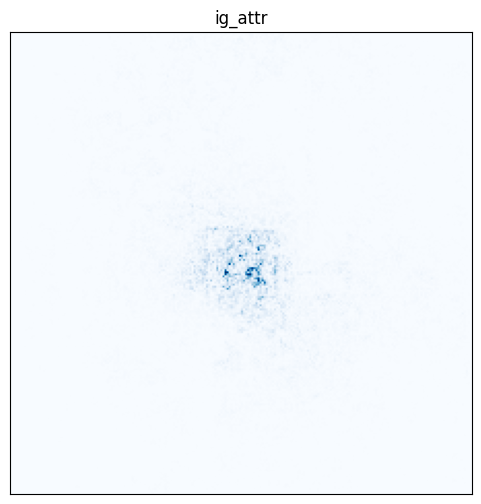

In [31]:
_ = visualization.visualize_image_attr(ig_attr_sample, method="heat_map", title="ig_attr", sign="absolute_value")

In [32]:
smooth_ig_attr_sample = gaussian_filter(ig_attr_sample, sigma=sigma)

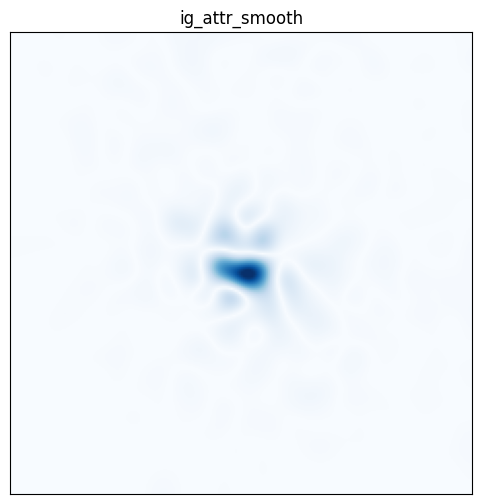

In [33]:
_ = visualization.visualize_image_attr(smooth_ig_attr_sample, method="heat_map", title="ig_attr_smooth", sign="absolute_value")

In [34]:
min_x, max_x, min_y, max_y = get_box(smooth_ig_attr_sample, np.prod(fg_size))

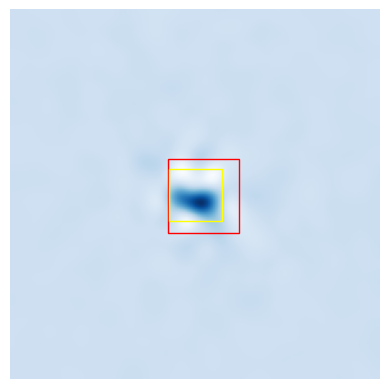

In [35]:
show_rects((min_x, min_y, max_x, max_y), (pos[0], pos[1], pos[0]+32, pos[1]+32), smooth_ig_attr_sample)
if saveflag:
    plt.savefig("IG", dpi=300, bbox_inches='tight')

In [36]:
print('iou score is', calculate_iou((min_x, min_y, max_x-min_x, max_y-min_y), (pos[0], pos[1], 32, 32)))

iou score is 0.5291989664082687


## DeepLift

In [37]:
dl_attr = dl.attribute(images, 0*torch.ones_like(images).to(device), target=preds.view(-1))
dl_attr_sample = np.transpose(dl_attr[sample_idx].squeeze().cpu().detach().numpy(), (1, 2, 0))

/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/geshi/captum/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


/home/geshi/captum/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


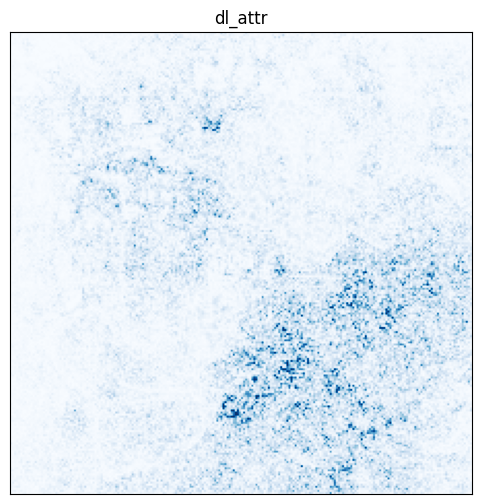

In [38]:
_ = visualization.visualize_image_attr(dl_attr_sample, method="heat_map", title="dl_attr", sign="absolute_value")

In [39]:
smooth_dl_attr_sample = gaussian_filter(dl_attr_sample, sigma=sigma)

/home/geshi/captum/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


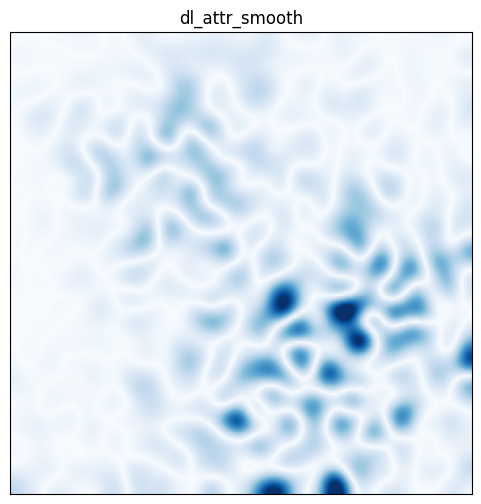

In [40]:
_ = visualization.visualize_image_attr(smooth_dl_attr_sample, method="heat_map", title="dl_attr_smooth", sign="absolute_value")

In [41]:
min_x, max_x, min_y, max_y = get_box(smooth_dl_attr_sample, np.prod(fg_size))

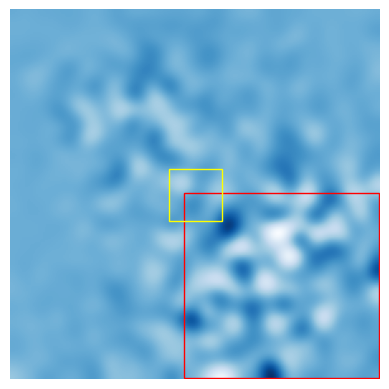

In [42]:
show_rects((min_x, min_y, max_x, max_y), (pos[0], pos[1], pos[0]+32, pos[1]+32), smooth_dl_attr_sample)
if saveflag:
    plt.savefig("DL", dpi=300, bbox_inches='tight')

In [43]:
print('iou score is', calculate_iou((min_x, min_y, max_x-min_x, max_y-min_y), (pos[0], pos[1], 32, 32)))

iou score is 0.02823308542133006


## Feature Ablation

In [44]:
feature_mask = np.arange(49)

In [45]:
feature_mask = feature_mask.reshape((7,7,1)).repeat((32), axis=-1).reshape(7, 224)

In [46]:
feature_mask = np.tile(np.expand_dims(feature_mask, 1), (32, 1)).reshape(224, 224)

In [47]:
feature_mask=torch.from_numpy(feature_mask)

In [48]:
fa_attr = fa.attribute(images, 0*torch.ones_like(images).to(device), target=preds.view(-1), feature_mask=feature_mask.to(device))
fa_attr_sample = np.transpose(fa_attr[sample_idx].squeeze().cpu().detach().numpy(), (1, 2, 0))

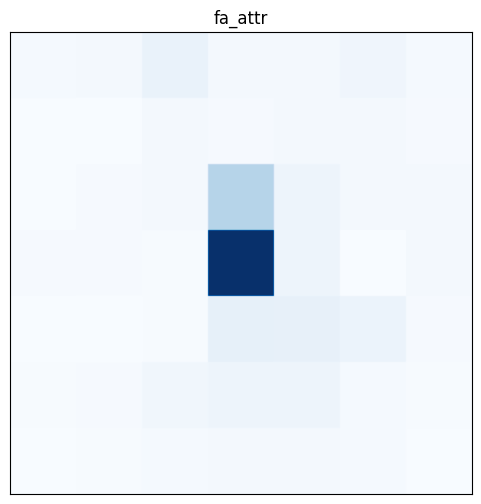

In [49]:
_ = visualization.visualize_image_attr(fa_attr_sample, method="heat_map", title="fa_attr", sign="absolute_value")

In [50]:
smooth_fa_attr_sample = gaussian_filter(fa_attr_sample, sigma=sigma)

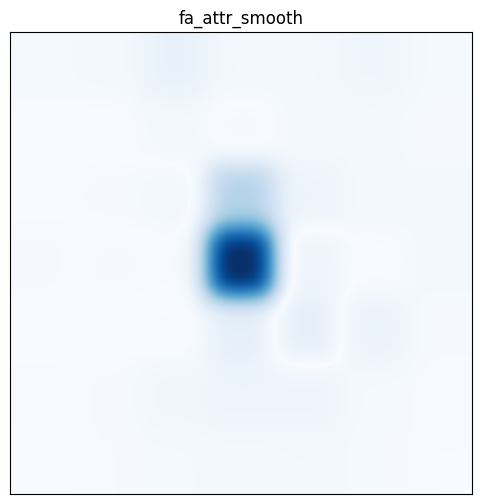

In [51]:
_ = visualization.visualize_image_attr(smooth_fa_attr_sample, method="heat_map", title="fa_attr_smooth", sign="absolute_value")

In [52]:
min_x, max_x, min_y, max_y = get_box(smooth_fa_attr_sample, np.prod(fg_size))

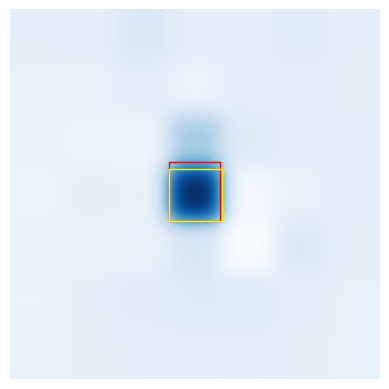

In [53]:
show_rects((min_x, min_y, max_x, max_y), (pos[0], pos[1], pos[0]+32, pos[1]+32), smooth_fa_attr_sample)
if saveflag:
    plt.savefig("FA", dpi=300, bbox_inches='tight')

In [54]:
print('iou score is', calculate_iou((min_x, min_y, max_x-min_x, max_y-min_y), (pos[0], pos[1], 32, 32)))

iou score is 0.8641114982578397
